# Time Series Prediction

In [294]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
import json
import random

## Read in Data

In [275]:
# Read in feature data
with open('../../../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        print(f"Feature not used: {i}")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input features: {feature_data.shape}")
#feature_data.head()

Feature not used: E_Mio.tonnes_CO2
Feature not used: M_Mio.tonnes_CO2
Feature not used: ECO_Mio.tonnes_CO2
Feature not used: Total_CO2_Emission
Shape input features: (111, 40)


In [276]:
# Read in emission data
emission_data = pd.read_csv('../../../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')
# Take only the emissions on which we have indicators
emission_data = emission_data[len(emission_data)-feature_data.shape[0]:]
print(f"Shape output data: {emission_data.shape}")

Shape output data: (111,)


In [277]:
# Convert an array of values into a dataset matrix
def sliding_window(input, output, look_back=1, horizon=1, shuffle=False):
	dataX, dataY = [], []
	if len(input) != len(output):
		raise ValueError('Input and ouput do not have same length!')
	for i in range(len(input)-look_back-horizon):
		dataX.append(input[i:(i+look_back)])
		dataY.append(output[(i+look_back):(i+look_back+horizon)])
	# Shuffle windows
	if shuffle is True:
		dataX, dataY = shuffle(dataX, dataY, random_state=0)
	return np.array(dataX), np.array(dataY)

In [278]:
from keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [279]:
scaler = StandardScaler()
feature_data = scaler.fit_transform(feature_data)

look_back = 12  # months
horizon = 6     # months
split_ratio = 0.8
shuffle = True

# Split into train and test sets
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back+horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Multilayer Perceptron (MLP)

In [280]:
# Regressions forecast model with windowing method
def train_model(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
    model = Sequential()
    # Flatten array if input is matrix
    if len(trainX.shape) >= 3:
        model.add(Flatten())
        model.add(Dense(look_back, input_dim=trainX.shape[2]*look_back, activation='relu'))
    model.add(Dense(24, input_dim=look_back, activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(horizon))
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [281]:
def train_lstm(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100, restore_best_weights=True)
    
    model = Sequential(name='LSTM')
    
    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    #model.add(LSTM(96, return_sequences=True, name="LSTM_3"))
    #model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    history = model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

In [308]:
def train_cnn(trainX, trainY, testX,  testY, lock_back, horizon):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)
    model = Sequential(name='CNN')    

    model.add(InputLayer(input_shape=(look_back, trainX.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', name="Conv_1"))
    model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', name="Conv_2"))
    model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    model.add(Dense(16, activation='elu', name='Dense_1'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=[r2_keras])
    model.fit(trainX, trainY, validation_split=0.2, epochs=250, batch_size=2, verbose=2, callbacks=[es])
    # Estimate model performance
    trainScore = model.evaluate(trainX, trainY, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
    testScore = model.evaluate(testX, testY, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

    # Generate predictions for training
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    return model, trainPredict, testPredict

## Input: Emissions

### Create Dataset

In [282]:
# Emissions as input
trainX, trainY = sliding_window(emission_data[0:train_size],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(emission_data[train_size:len(emission_data)],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [283]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

Shape of data:
(70, 12)
(70, 6)
(5, 12)
(5, 6)


### Train Model

In [284]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan

# Train model and generate predictions
model, trainPredict, testPredict = train_model(trainX, trainY, testX, testY, look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Epoch 1/100
 - 0s - loss: 4810.5832
Epoch 2/100
 - 0s - loss: 1675.8142
Epoch 3/100
 - 0s - loss: 553.0249
Epoch 4/100
 - 0s - loss: 153.6520


C:\Users\Johan\anaconda3\envs\ami-cpu\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 5/100
 - 0s - loss: 39.0773
Epoch 6/100
 - 0s - loss: 27.7755
Epoch 7/100
 - 0s - loss: 27.4229
Epoch 8/100
 - 0s - loss: 26.3914
Epoch 9/100
 - 0s - loss: 25.1807
Epoch 10/100
 - 0s - loss: 25.5643
Epoch 11/100
 - 0s - loss: 24.7945
Epoch 12/100
 - 0s - loss: 25.0091
Epoch 13/100
 - 0s - loss: 24.6859
Epoch 14/100
 - 0s - loss: 24.0933
Epoch 15/100
 - 0s - loss: 23.3805
Epoch 16/100
 - 0s - loss: 23.5632
Epoch 17/100
 - 0s - loss: 22.5966
Epoch 18/100
 - 0s - loss: 21.2854
Epoch 19/100
 - 0s - loss: 21.7122
Epoch 20/100
 - 0s - loss: 20.4762
Epoch 21/100
 - 0s - loss: 20.4032
Epoch 22/100
 - 0s - loss: 20.1092
Epoch 23/100
 - 0s - loss: 20.2930
Epoch 24/100
 - 0s - loss: 19.4457
Epoch 25/100
 - 0s - loss: 19.7753
Epoch 26/100
 - 0s - loss: 18.7677
Epoch 27/100
 - 0s - loss: 17.3600
Epoch 28/100
 - 0s - loss: 17.1033
Epoch 29/100
 - 0s - loss: 16.2521
Epoch 30/100
 - 0s - loss: 17.4231
Epoch 31/100
 - 0s - loss: 16.4933
Epoch 32/100
 - 0s - loss: 15.3516
Epoch 33/100
 - 0s - loss

### Prediction and Plot

Forecast: [[70.59049  69.79876  66.720055 64.3723   63.237705 62.124157]]


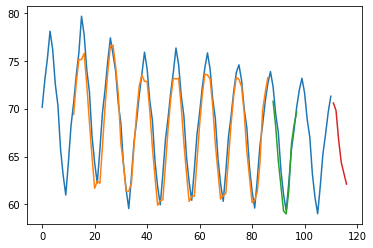

In [285]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

X = np.zeros((1, look_back))
X[0] = emission_data[len(emission_data)-look_back:]
predict = model.predict(X)
forecastPlot[len(emission_data):len(emission_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()

## Input: Features

### Create Dataset

In [301]:
# Features as input
trainX, trainY = sliding_window(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)
testX, testY = sliding_window(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

In [302]:
print("Shape of data:")
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
testY

Shape of data:
(70, 12, 40)
(70, 6)
(5, 12, 40)
(5, 6)


array([[71.66739555, 68.89877353, 67.01921089, 63.1472728 , 60.68784891,
        59.03368864],
       [68.89877353, 67.01921089, 63.1472728 , 60.68784891, 59.03368864,
        61.9336371 ],
       [67.01921089, 63.1472728 , 60.68784891, 59.03368864, 61.9336371 ,
        65.2684815 ],
       [63.1472728 , 60.68784891, 59.03368864, 61.9336371 , 65.2684815 ,
        67.30914151],
       [60.68784891, 59.03368864, 61.9336371 , 65.2684815 , 67.30914151,
        69.58895439]])

### Train Model

In [303]:
#Varying number of features

num_of_feats = 30

trainX = trainX[:, :, :num_of_feats]
print(trainX.shape)
testX = testX[:, :, :num_of_feats]
print(testX.shape)

(70, 12, 30)
(5, 12, 30)


In [309]:
# Create and fit Multilayer Perceptron model for every indicator
trainPredictPlot = np.empty_like(emission_data)
trainPredictPlot[:] = np.nan
testPredictPlot = np.empty_like(emission_data)
testPredictPlot[:] = np.nan



# Train model and generate predictions
model, trainPredict, testPredict = train_cnn(trainX, trainY, testX, testY,
                                               look_back, horizon)

# Shift train predictions for plotting
for t in range(len(trainPredict)):
    trainPredictPlot[t+look_back:t+look_back+horizon] = trainPredict[t, :]
for t in range(len(testPredict)):
    testPredictPlot[len(trainPredict)+t+look_back+horizon:len(trainPredict)+
                    t+look_back+(horizon*2)] = testPredict[t, :]

Train on 56 samples, validate on 14 samples
Epoch 1/250
 - 1s - loss: 4775.0627 - val_loss: 4574.2831
Epoch 2/250
 - 0s - loss: 4703.2550 - val_loss: 4530.0044
Epoch 3/250
 - 0s - loss: 4618.8208 - val_loss: 4455.5020
Epoch 4/250
 - 0s - loss: 4419.7793 - val_loss: 4334.9978
Epoch 5/250
 - 0s - loss: 4179.5927 - val_loss: 4152.9632
Epoch 6/250
 - 0s - loss: 3937.0773 - val_loss: 3914.2399
Epoch 7/250
 - 0s - loss: 3482.2428 - val_loss: 3523.7629
Epoch 8/250
 - 0s - loss: 2925.0990 - val_loss: 3003.3193
Epoch 9/250
 - 0s - loss: 2533.2488 - val_loss: 2275.7211
Epoch 10/250
 - 0s - loss: 1829.9866 - val_loss: 1603.3786
Epoch 11/250
 - 0s - loss: 1354.8152 - val_loss: 1287.7129
Epoch 12/250
 - 0s - loss: 871.8102 - val_loss: 975.7458
Epoch 13/250
 - 0s - loss: 659.5422 - val_loss: 947.4651
Epoch 14/250
 - 0s - loss: 518.1690 - val_loss: 1037.2829
Epoch 15/250
 - 0s - loss: 598.6790 - val_loss: 1256.2128
Epoch 16/250
 - 0s - loss: 599.5764 - val_loss: 1467.9979
Epoch 17/250
 - 0s - loss: 4

### Prediction and Plot

Forecast: [[62.613544 58.54102  68.17     68.80457  62.70614  55.543144]]


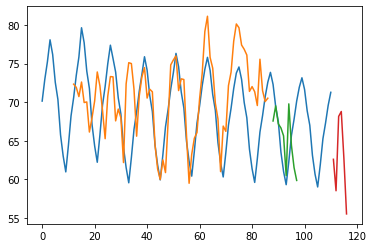

In [310]:
# Forecast predictions
forecastPlot = np.zeros((len(emission_data) + horizon))
forecastPlot[:] = np.nan

# Features
#X = np.zeros((1, look_back, feature_data.shape[1]))
X = np.zeros((1, look_back, num_of_feats))
#X[0] = feature_data[len(feature_data)-look_back:, :]
X[0] = feature_data[len(feature_data)-look_back:, :num_of_feats]
predict = model.predict(X)
forecastPlot[len(feature_data):len(feature_data)+horizon] = predict[:]

print(f"Forecast: {predict}")

# Plot baseline, training, test and forecast
plt.plot(emission_data[:])
plt.plot(trainPredictPlot[:])
plt.plot(testPredictPlot[:])
plt.plot(forecastPlot[:])
plt.show()